# DNN: analysis with Keras of 2D data

In [20]:
import numpy        as     np
#Original
#from   keras.models import Sequential # basic NN
#from  keras.layers import Dense, Dropout

#Ema's Laptop
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD 
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint


#dense : normal layer(?)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

%run nonlinear_function.py

# training data
perc_train = 0.8

## Load data

In [2]:
# Keras works with numpy arrays: just use them from the start
TYPE  = 1
x_4K  = np.loadtxt( filename( 'data_4K',   TYPE), delimiter = ' ' )
y_4K  = np.loadtxt( filename( 'labels_4K', TYPE), delimiter = ' ' )
x_1K  = np.loadtxt( filename( 'data_1K',   TYPE), delimiter = ' ' )
y_1K  = np.loadtxt( filename( 'labels_1K', TYPE), delimiter = ' ' )
x_16K = np.loadtxt( filename( 'data_16K',  TYPE), delimiter = ' ' )
y_16K = np.loadtxt( filename( 'labels_16K',TYPE), delimiter = ' ' )

N_4K  = len( x_4K  )
N_1K  = len( x_1K  )
N_16K = len( x_16K )

# dim of a sample
L = len( x_4K[0] )

N_train_4K = int(perc_train * N_4K)
#print(f'original data: {N_4K}\ntrain: {N_train_4K}')
N_train_1K = int(perc_train * N_1K)
#print(f'data: {N_1K}\ntrain: {N_train_1K}')
N_train_16K = int(perc_train * N_16K)
#print(f'data: {N_16K}\ntrain: {N_train_16K}')

## Split training and test data

In [3]:
# DATA AUGMENTATION: for each data (x1, x2) are generated 10 points (x +ai, y + bi) for i = 1, .. , 10.

std   = 1
noise = np.random.normal( loc   = 0, scale = std, size = (N_train_4K*10, 2)) 
x_train_noise = np.zeros( shape = ( N_train_4K*10, 2 ))
y_train_noise = np.zeros( shape = ( N_train_4K*10, 1 ))
for j in range ( N_train_4K ):
    x_train_noise[j*10] = x_4K[j] + noise[j*10]
    y_train_noise[j*10] = y_4K[j]
    #mean = x_train_noise[j*10]
    #cov  = [[0.1, 0], [0, 0.1]] 
    #print(x_train_noise[j*10], y_train_noise[j*10])
    for i in range (9):
        x_train_noise[(j*10)+i+1] = x_4K[j] + noise[(j*10)+i+1]
        y_train_noise[(j*10)+i+1] = y_4K[j]
        #print(x_train_noise[(j*10)+i+1], y_train_noise[(j*10)+i+1])


Train 4K: 3200 		 Validation 4K: 800
Train 1K: 800 		 Validation 1K: 200
Train 16K: 12800 	 Validation 16K: 3200
Train noise: 32000 	 Validation noise: 800


Text(0.5, 1.0, 'data augmented')

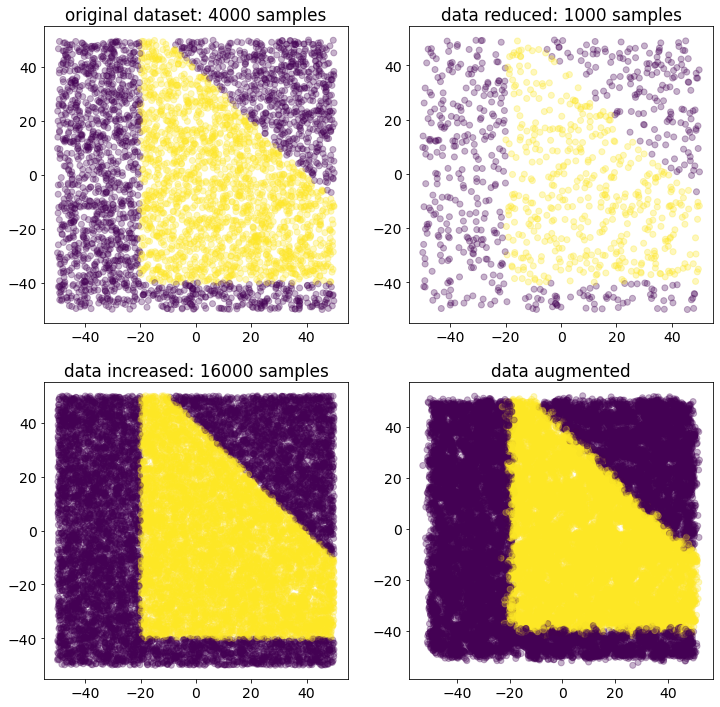

In [4]:
x_train_4K,  y_train_4K  = x_4K[0:N_train_4K],   y_4K[0:N_train_4K]
x_valid_4K,  y_valid_4K  = x_4K[N_train_4K:],    y_4K[N_train_4K:]
x_train_1K,  y_train_1K  = x_1K[0:N_train_1K],   y_1K[0:N_train_1K]
x_valid_1K,  y_valid_1K  = x_1K[N_train_1K:],    y_1K[N_train_1K:]
x_train_16K, y_train_16K = x_16K[0:N_train_16K], y_16K[0:N_train_16K]
x_valid_16K, y_valid_16K = x_16K[N_train_16K:],  y_16K[N_train_16K:]

x_noise       = np.concatenate([x_train_noise, x_valid_4K])
y_valid_noise = y_valid_4K.reshape(len(y_valid_4K), 1)
y_noise       =np.concatenate([y_train_noise, y_valid_noise])

print( "Train 4K:",    len(x_train_4K), "\t\t Validation 4K:",     len(x_valid_4K) )
print( "Train 1K:",    len(x_train_1K), "\t\t Validation 1K:",     len(x_valid_1K) )
print( "Train 16K:",   len(x_train_16K), "\t Validation 16K:",     len(x_valid_16K))
print( "Train noise:", len(x_train_noise), "\t Validation noise:", len(x_valid_4K) ) #I DON'T KNOW WHAT TO USE AS DIMENSION FOR THIS THE VALIDATION SET

fig, AX = plt.subplots (2, 2, figsize = (12, 12.))
ax = AX[0][0]
ax.scatter(x_4K[:,0], x_4K[:,1], c = y_4K, alpha = 0.3 )
ax.set_title("original dataset: 4000 samples")
ax = AX[0][1] 
ax.scatter(x_1K[:,0], x_1K[:,1], c = y_1K, alpha = 0.3 )
ax.set_title("data reduced: 1000 samples")
ax = AX[1][0]
ax.scatter(x_16K[:,0], x_16K[:,1], c = y_16K, alpha = 0.3 )
ax.set_title("data increased: 16000 samples")
ax = AX[1][1]
ax.scatter(x_noise[:,0], x_noise[:,1], c = y_noise, alpha = 0.3 )
ax.set_title("data augmented")

## Rescale input data

In [5]:
def Rescale( x ):
    # I cal also take away the mean
    #return (x-x.mean())/np.sqrt(x.var())
    return x / 50

x_train_4K    = Rescale( x_train_4K )
x_valid_4K    = Rescale( x_valid_4K )
x_train_1K    = Rescale( x_train_1K )
x_valid_1K    = Rescale( x_valid_1K )
x_train_16K   = Rescale( x_train_16K )
x_valid_16K   = Rescale( x_valid_16K )
x_train_noise = Rescale( x_train_noise )
x_valid_noise = Rescale( x_valid_4K )

## Define the model with Keras

In [12]:
# reproducibility
np.random.seed(12345)

CASE = 1

if CASE ==1 :
    model = Sequential()
    #then I continue adding layers
    model.add(Dense(L, input_shape = (L, ), activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    nepoch = 400 # le volte in cui faccio lo scan sul database, keras di default fa lo shuffle dopo ogni epoch e quindi le minibatch sono diverse
    
if CASE ==2 :
    model = Sequential()
    model.add(Dense(L, input_shape = (L,),activation = 'sigmoid'))
    model.add(Dense(3, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    nepoch = 400

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


## Optimization method and cost function

In [14]:
model.compile(loss = 'binary_crossentropy',
              #optimizer = 'RMSprop',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.save_weights('initial_weights.h5')

## Training

In [8]:
dX = 2                        
X1 = np.arange(-50,50+dX, dX) #from -50 to 50 with only even number
LG = len(X1)                  # 51
grid = np.zeros((LG*LG,2))    # 2601, 
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

#print(grid)

# RESCALE
grid_r = grid/50

51 2601
[50. 50.]


In [21]:
#mcp_save_1K = ModelCheckpoint('.mdl_wts_fit_1K.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Loading standard weights 
model.load_weights('initial_weights.h5')

fit_1K  = model.fit(x_train_1K, y_train_1K,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_1K, y_valid_1K), 
                      verbose = False)

pred_1K = model.predict(grid_r)

In [10]:
#mcp_save_4K = ModelCheckpoint('.mdl_wts_fit_4K.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Loading standard weights 
model.load_weights('initial_weights.h5')

fit_4K  = model.fit(x_train_4K, y_train_4K,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_4K, y_valid_4K), 
                      verbose = False)

pred_4K = model.predict(grid_r)

In [11]:
model.load_weights('initial_weights.h5')

fit_16K   = model.fit(x_train_16K, y_train_16K,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_16K, y_valid_16K), 
                      verbose = False)

pred_16K = model.predict(grid_r)

In [15]:
model.load_weights('initial_weights.h5')

fit_noise = model.fit(x_train_noise, y_train_noise,
                      epochs = nepoch, batch_size = 50,
                      validation_data = (x_valid_4K, y_valid_4K), 
                      verbose = False)

pred_noise = model.predict(grid_r)

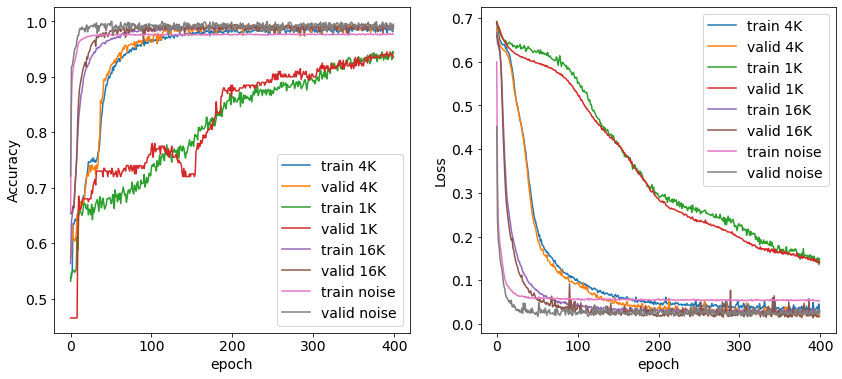

In [22]:
fig, AX = plt.subplots (1, 2, figsize = (14, 6.))
ax = AX[0]
ax.plot(fit_4K.history['accuracy'], label = 'train 4K')
ax.plot(fit_4K.history['val_accuracy'], label = 'valid 4K')
ax.plot(fit_1K.history['accuracy'], label = 'train 1K')
ax.plot(fit_1K.history['val_accuracy'], label = 'valid 1K')
ax.plot(fit_16K.history['accuracy'], label = 'train 16K')
ax.plot(fit_16K.history['val_accuracy'],   label = 'valid 16K')
ax.plot(fit_noise.history['accuracy'],     label = 'train noise')
ax.plot(fit_noise.history['val_accuracy'], label = 'valid noise')
ax.set_xlabel('epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax = AX[1]
ax.plot(fit_4K.history['loss'], label = 'train 4K')
ax.plot(fit_4K.history['val_loss'], label = 'valid 4K')
ax.plot(fit_1K.history['loss'], label = 'train 1K')
ax.plot(fit_1K.history['val_loss'], label = 'valid 1K')
ax.plot(fit_16K.history['loss'], label = 'train 16K')
ax.plot(fit_16K.history['val_loss'], label = 'valid 16K')
ax.plot(fit_noise.history['loss'], label = 'train noise')
ax.plot(fit_noise.history['val_loss'], label = 'valid noise')
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

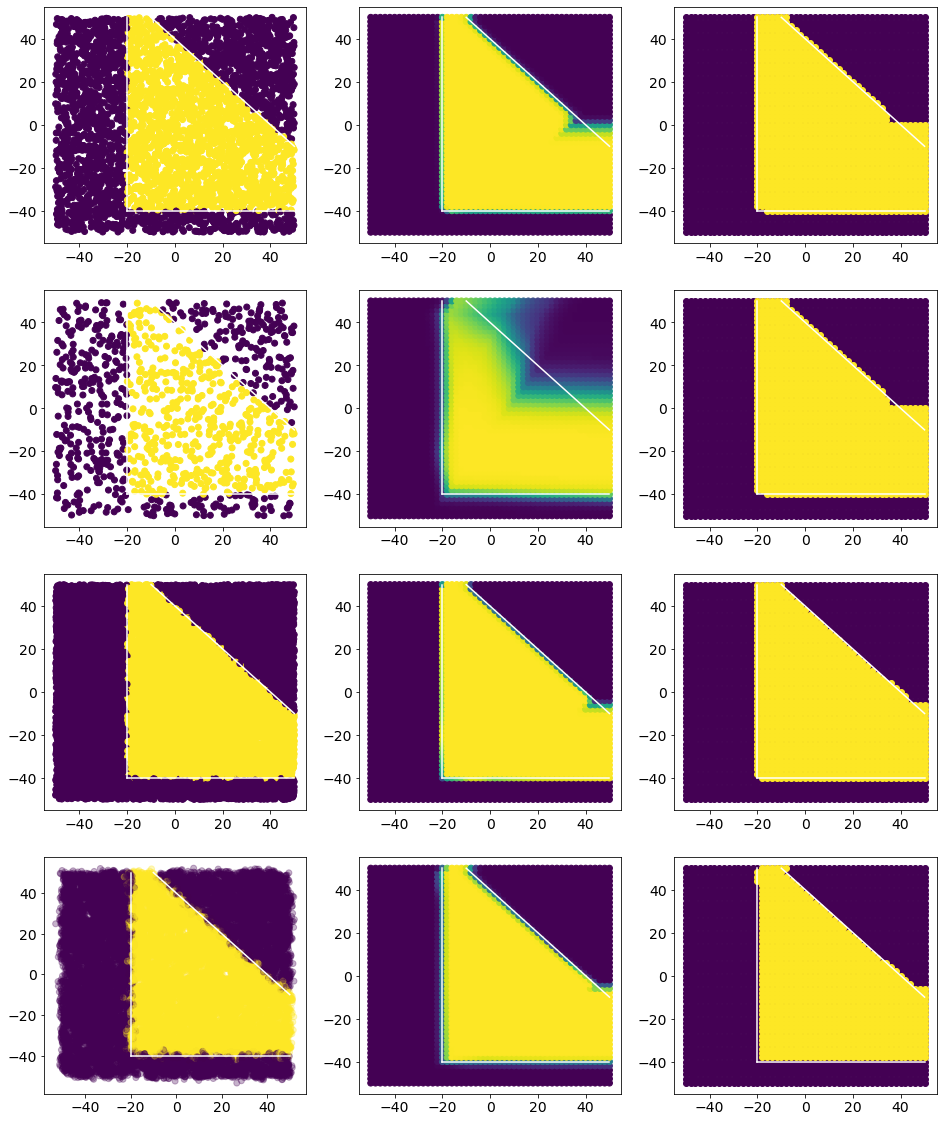

In [23]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
fig,AX=plt.subplots(4,3,figsize=(16,20.))

ax=AX[0][0]
ax.scatter(x_4K[:,0],x_4K[:,1],c=y_4K)
boundaries()
ax=AX[0][1]
ax.scatter(grid[:,0],grid[:,1],c=pred_4K)
boundaries()
ax=AX[0][2]
W1=np.where(pred_4K>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

ax=AX[1][0]
ax.scatter(x_1K[:,0],x_1K[:,1],c=y_1K)
boundaries()
ax=AX[1][1]
ax.scatter(grid[:,0],grid[:,1],c=pred_1K)
boundaries()
ax=AX[1][2]
W1=np.where(pred_4K>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

ax=AX[2][0]
ax.scatter(x_16K[:,0],x_16K[:,1],c=y_16K)
boundaries()
ax=AX[2][1]
ax.scatter(grid[:,0],grid[:,1],c=pred_16K)
boundaries()
ax=AX[2][2]
W1=np.where(pred_16K>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

ax=AX[3][0]
ax.scatter(x_noise[:,0], x_noise[:,1], c = y_noise, alpha = 0.3 )
boundaries()
ax=AX[3][1]
ax.scatter(grid[:,0],grid[:,1],c = pred_noise)
boundaries()
ax=AX[3][2]
W1=np.where(pred_noise>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],   c="#440154")
ax.scatter(grid[W1,0],grid[W1,1], c="#fde725")
boundaries()
plt.show


# Grid Search Validation